# Advanced Lane Finding Project - Data Analysis & Exploration

The overall goals of the Advanced Lane Line project include:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In this data analysis/exploration project, we explore data in each of the steps above and make decision towards our final solution for the project.

---
## 1. Camera Calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
from image_functions import *

images = glob.glob("./camera_cal/calibration*.jpg")
nx = 9 #enter the number of inside corners in x
ny = 6 #enter the number of inside corners in y
print("Calibrating camera ...")
ret, mtx, dist, rvecs, tvecs = calibrate_camera(images, nx, ny)
print("Done.")

Calibrating camera ...
Done.


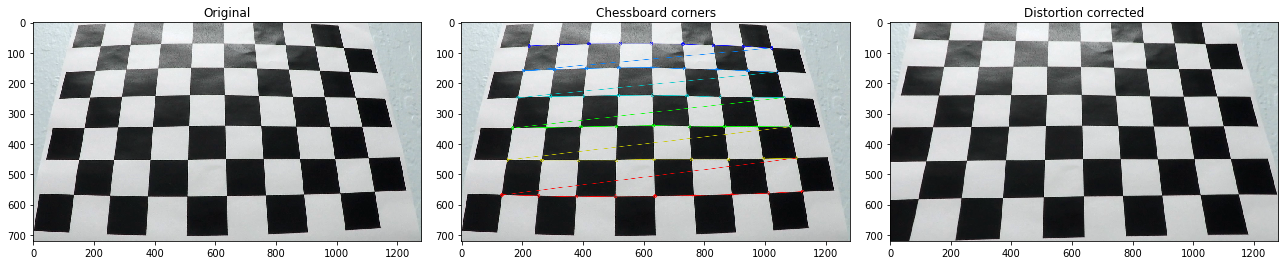

In [2]:
# camera calibration - steps
img = cv2.imread('./camera_cal/calibration3.jpg')

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
if ret == True:
    corners_img = np.copy(img)
    # draw chessboard corners
    cv2.drawChessboardCorners(corners_img, (nx, ny), corners, ret)

# undist image
undist_img = undistort_image(img, mtx, dist)

# plot and save image
images_to_plot = [img, corners_img, undist_img]
titles_to_plot = ['Original', 'Chessboard corners', 'Distortion corrected']
out_file = "calibration.png"
plot_images(rows=1, cols=3, images_to_plot=images_to_plot, titles_to_plot=titles_to_plot, out_file=out_file)

## 2. Undistort Image

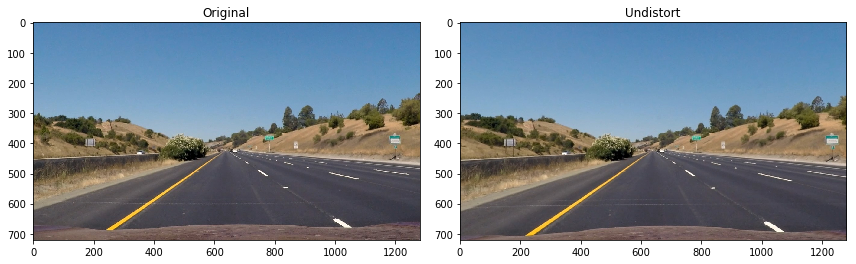

In [3]:
# pick a test image
img = cv2.imread('./test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

undist_img = undistort_image(img, mtx, dist)

# plot and save image
images_to_plot = [img, undist_img]
titles_to_plot = ['Original', 'Undistort']
out_file = "undistort.png"
plot_images(rows=1, cols=2, images_to_plot=images_to_plot, titles_to_plot=titles_to_plot, out_file=out_file)

## 3. Unwarp Image

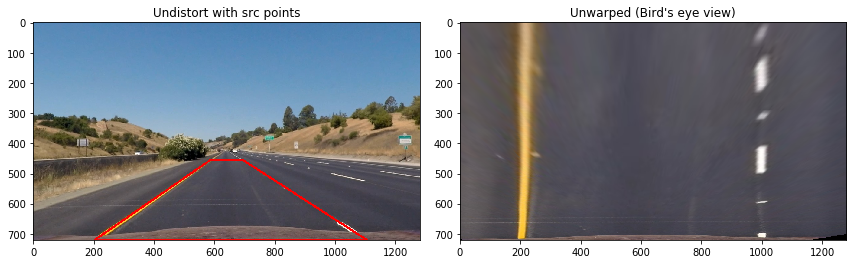

In [4]:
img_height, img_width = undist_img.shape[:2]

'''
# source points
top_left = (588, 454)
top_right = (692, 454)
bottom_left = (203, 720)
bottom_right = (1105, 720)

src = np.float32([top_right,
                  bottom_right, 
                  bottom_left, 
                  top_left])

# desired destination
dst_top_left = (200, 0)
dst_top_right = (1000, 0)
dst_bottom_right = (1000, 720)
dst_bottom_left = (200, 720)

dst = np.float32([dst_top_right,
                  dst_bottom_right, 
                  dst_bottom_left, 
                  dst_top_left])
'''
src, dst = get_src_dst_coordinates()

# unwarp
unwarp, M, Minv = unwarp_image(undist_img, src, dst)

# draw lines for the source points, for plotting
undist_img_plot = np.copy(undist_img)
cv2.line(undist_img_plot, tuple(src[2]), tuple(src[1]), color=(255,0,0), thickness=5)
cv2.line(undist_img_plot, tuple(src[1]), tuple(src[0]), color=(255,0,0), thickness=5)
cv2.line(undist_img_plot, tuple(src[0]), tuple(src[3]), color=(255,0,0), thickness=5)
cv2.line(undist_img_plot, tuple(src[3]), tuple(src[2]), color=(255,0,0), thickness=5)

# unwarp image for plotting
unwarp_img_plot, M_plot, Minv_plot = unwarp_image(undist_img_plot, src, dst)

# plot and save image
images_to_plot = [undist_img_plot, unwarp]
titles_to_plot = ['Undistort with src points', "Unwarped (Bird's eye view)"]
out_file = "unwarped.png"
plot_images(rows=1, cols=2, images_to_plot=images_to_plot, titles_to_plot=titles_to_plot, out_file=out_file)

## 4. Color Channels Thresholding

### 4.1 Image Comparison (in different color channels)

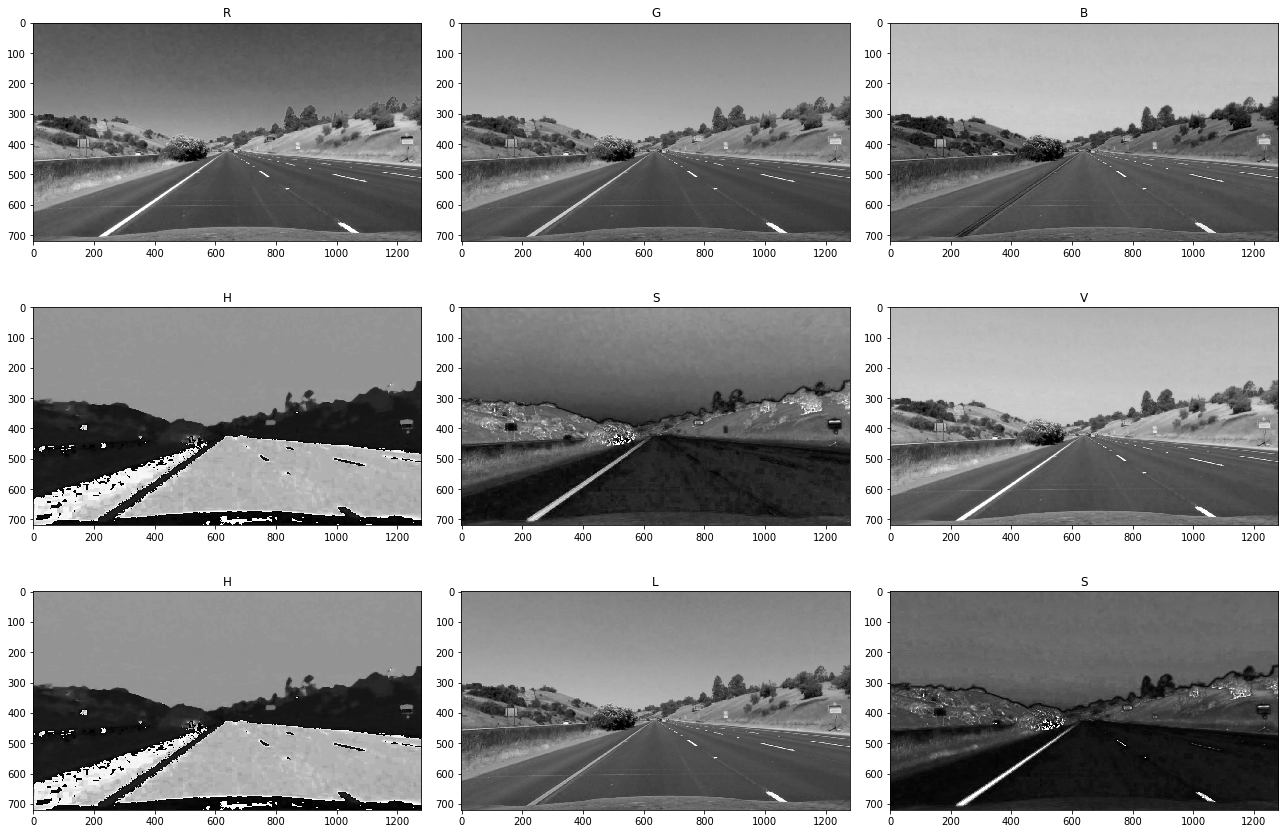

In [5]:
def plot_image_color_spaces(img_RGB):
    # setup image channels
    img_R = img_RGB[:,:,0]
    img_G = img_RGB[:,:,1]
    img_B = img_RGB[:,:,2]
    img_HSV = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2HSV)
    img_H = img_HSV[:,:,0]
    img_S = img_HSV[:,:,1]
    img_V = img_HSV[:,:,2]
    img_HLS = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2HLS)
    img_H1 = img_HLS[:,:,0]
    img_L1 = img_HLS[:,:,1]
    img_S1 = img_HLS[:,:,2]
    
    # plot and save image
    images_to_plot = [img_R, img_G, img_B, img_H, img_S, img_V, img_H1, img_L1, img_S1]
    titles_to_plot = ['R','G','B','H','S','V','H','L','S']
    cmap_gray=['gray','gray','gray','gray','gray','gray','gray','gray','gray']
    out_file = "color_channels.png"
    plot_images(rows=3, cols=3, images_to_plot=images_to_plot, titles_to_plot=titles_to_plot, out_file=out_file, cmap=cmap_gray)
    
plot_image_color_spaces(undist_img)

### 4.2 RGB Colorspace

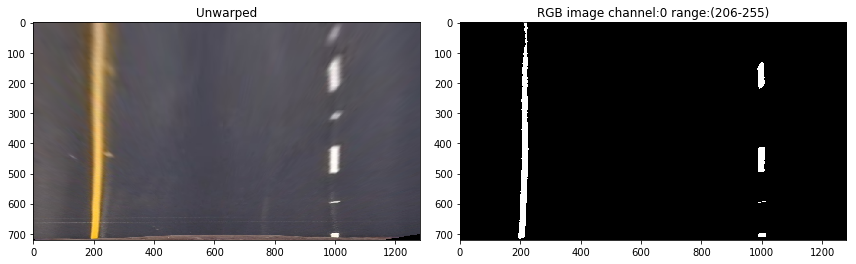

In [6]:
from ipywidgets import interact, interactive, fixed

def select(img, ch, thresh):
    channel = img[:,:,ch]
    out = np.zeros_like(channel)
    out[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return out

def updateRGB(ch, thresh_min, thresh_max):
    out_img = select(unwarp, ch, thresh=(thresh_min, thresh_max))
    
    # plot and save image
    images_to_plot = [unwarp, out_img]
    titles_to_plot = ['Unwarped', 'RGB image channel:{} range:({}-{})'.format(ch, thresh_min, thresh_max)]
    out_file = "colorspace_RGB_{}.png".format(ch)
    plot_images(rows=1, cols=2, images_to_plot=images_to_plot, titles_to_plot=titles_to_plot, out_file=out_file, cmap=[None,'gray'])

interact(updateRGB, 
         ch=(0,2),
         thresh_min=(0,255),
         thresh_max=(0,255))

### 4.3 HSV Colorspace

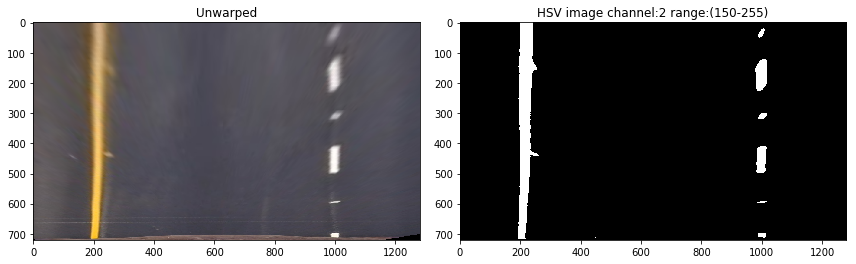

In [7]:
hsv = cv2.cvtColor(unwarp, cv2.COLOR_RGB2HSV)

def updateHSV(ch, thresh_min, thresh_max):
    out_img = select(hsv, ch, thresh=(thresh_min, thresh_max))

    # plot and save image
    images_to_plot = [unwarp, out_img]
    titles_to_plot = ['Unwarped', 'HSV image channel:{} range:({}-{})'.format(ch, thresh_min, thresh_max)]
    out_file = "colorspace_HSV_{}.png".format(ch)
    plot_images(rows=1, cols=2, images_to_plot=images_to_plot, titles_to_plot=titles_to_plot, out_file=out_file, cmap=[None,'gray'])

interact(updateHSV, 
         ch=(0,2),
         thresh_min=(0,255),
         thresh_max=(0,255))

### 4.4 HLS Colorspace

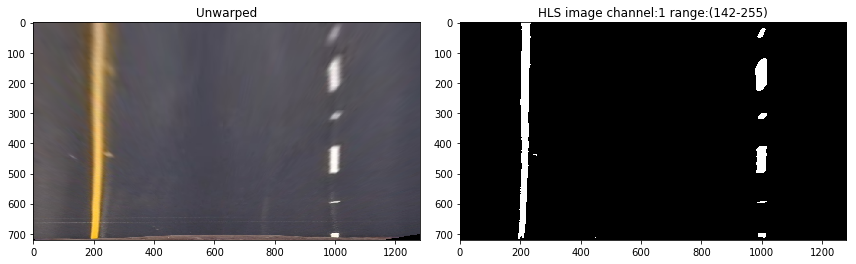

In [8]:
hls = cv2.cvtColor(unwarp, cv2.COLOR_RGB2HLS)

def updateHLS(ch, thresh_min, thresh_max):
    out_img = select(hls, ch, thresh=(thresh_min, thresh_max))

    # plot and save image
    images_to_plot = [unwarp, out_img]
    titles_to_plot = ['Unwarped', 'HLS image channel:{} range:({}-{})'.format(ch, thresh_min, thresh_max)]
    out_file = "colorspace_HLS_{}.png".format(ch)
    plot_images(rows=1, cols=2, images_to_plot=images_to_plot, titles_to_plot=titles_to_plot, out_file=out_file, cmap=[None,'gray'])

interact(updateHLS, 
         ch=(0,2),
         thresh_min=(0,255),
         thresh_max=(0,255))

### 4.5 Yellow color lane mask

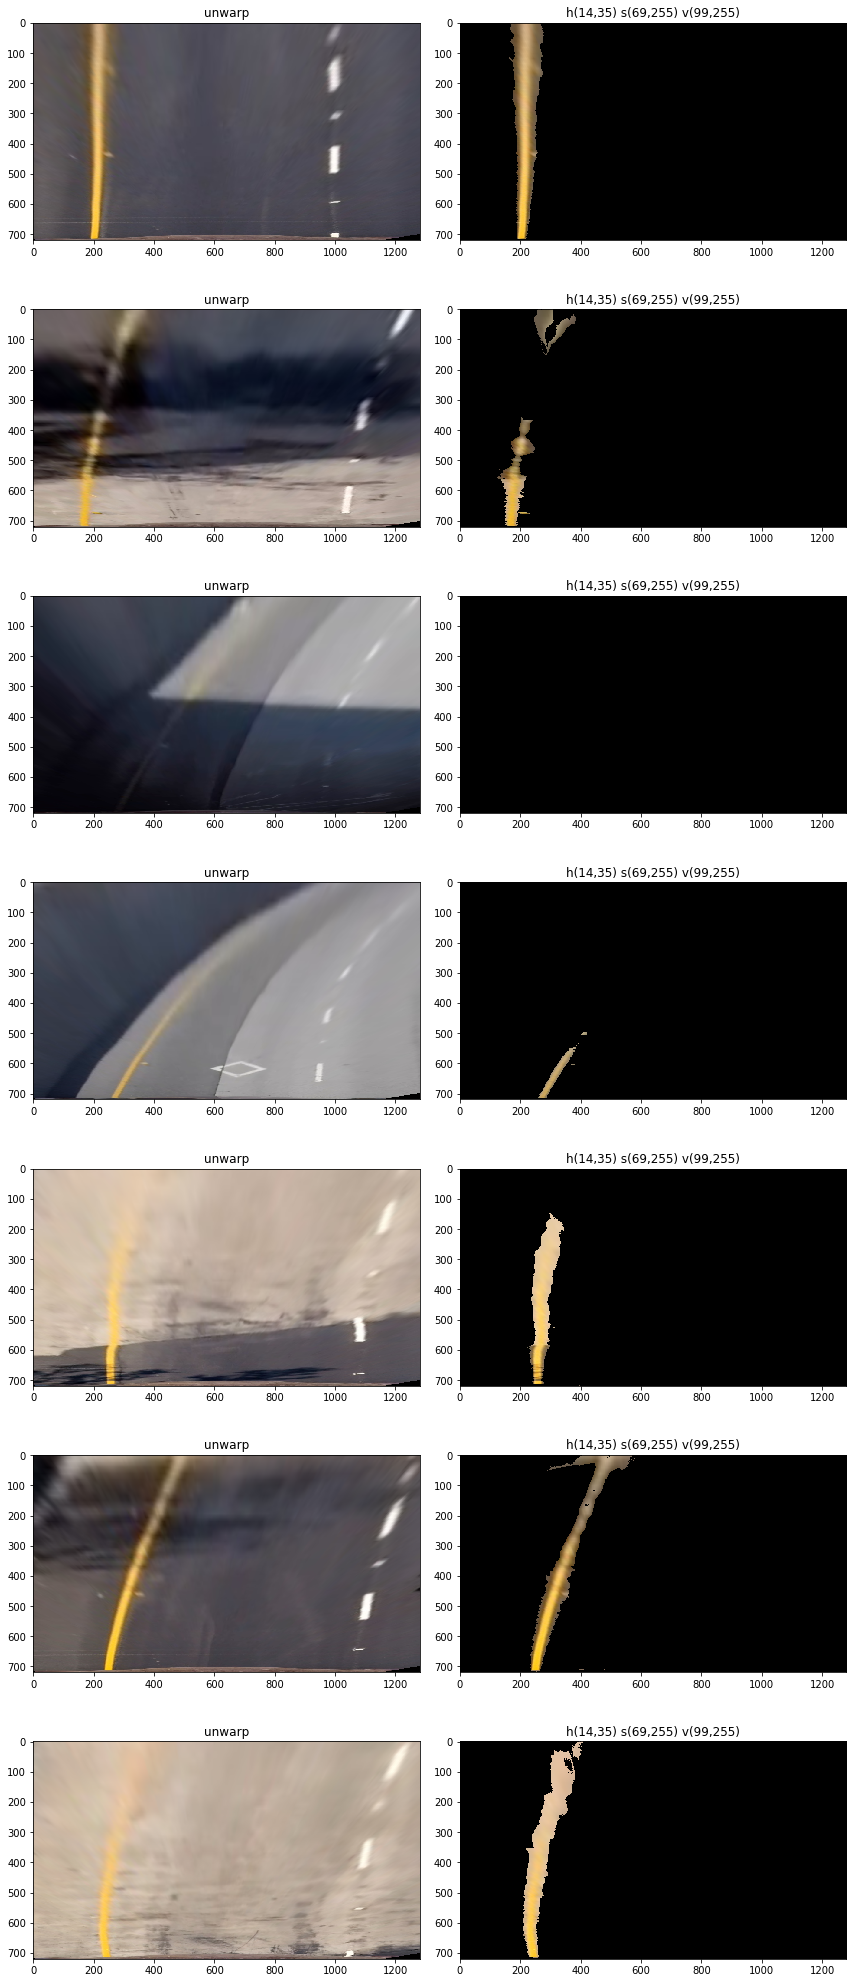

In [9]:
sample_filename_list = ['./test_images/straight_lines1.jpg', './test_images/test5.jpg', './test_images/org_134.jpg', './test_images/org_195.jpg', './test_images/test4.jpg','./test_images/test6.jpg','./test_images/test1.jpg']

samples_rgb = get_samples_rgb(sample_filename_list)
samples_unwarp, samples_undist, samples_M, samples_Minv = get_samples_unwarp(samples_rgb, mtx, dist, src, dst)

def updateHSVYellow(ch0_min, ch0_max, ch1_min, ch1_max, ch2_min, ch2_max):
    
    yellow_hsv_low  = np.array([ch0_min, ch1_min, ch2_min])
    yellow_hsv_high = np.array([ch0_max, ch1_max, ch2_max])

    images_to_plot = []
    titles_to_plot = []
    cmaps_to_plot = []
    for idx in range(len(samples_unwarp)):
        sample_unwarp = samples_unwarp[idx]
        hsv = cv2.cvtColor(sample_unwarp, cv2.COLOR_RGB2HSV)
        mask = color_mask(hsv, yellow_hsv_low, yellow_hsv_high)
        image = np.copy(sample_unwarp)
        out_img = cv2.bitwise_and(image, image, mask= mask)
        images_to_plot.append(sample_unwarp)
        images_to_plot.append(out_img)
        titles_to_plot.append('unwarp')
        titles_to_plot.append('h({},{}) s({},{}) v({},{})'.format(ch0_min, ch0_max, ch1_min, ch1_max, ch2_min, ch2_max))
        cmaps_to_plot.append(None)
        cmaps_to_plot.append(None)
        
    # plot and save image
    out_file = "hsv_yellow_masked.png"
    plot_images(rows=len(sample_filename_list), cols=2, images_to_plot=images_to_plot, titles_to_plot=titles_to_plot, out_file=out_file, cmap=cmaps_to_plot)

interact(updateHSVYellow, 
         ch0_min=(0,255),
         ch0_max=(0,255),
         ch1_min=(0,255),
         ch1_max=(0,255),
         ch2_min=(0,255),
         ch2_max=(0,255))

### 4.6 White color lane mask¶

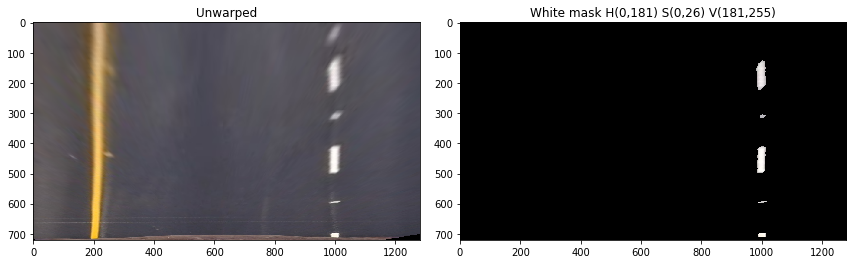

In [10]:
hsv = cv2.cvtColor(unwarp, cv2.COLOR_RGB2HSV)

def updateHSVWhite(ch0_min, ch0_max, ch1_min, ch1_max, ch2_min, ch2_max):
    image = np.copy(unwarp)
    white_hsv_low  = np.array([ch0_min, ch1_min, ch2_min])
    white_hsv_high = np.array([ch0_max, ch1_max, ch2_max])
    mask = color_mask(hsv, white_hsv_low, white_hsv_high)
    out_img = cv2.bitwise_and(image, image, mask= mask)

    # plot and save image
    images_to_plot = [unwarp, out_img]
    titles_to_plot = ['Unwarped', 'White mask H({},{}) S({},{}) V({},{})'.format(ch0_min, ch0_max, ch1_min, ch1_max, ch2_min, ch2_max)]
    out_file = "hsv_white_masked.png"
    plot_images(rows=1, cols=2, images_to_plot=images_to_plot, titles_to_plot=titles_to_plot, out_file=out_file, cmap=[None,None])

interact(updateHSVWhite, 
         ch0_min=(0,255),
         ch0_max=(0,255),
         ch1_min=(0,255),
         ch1_max=(0,255),
         ch2_min=(0,255),
         ch2_max=(0,255))

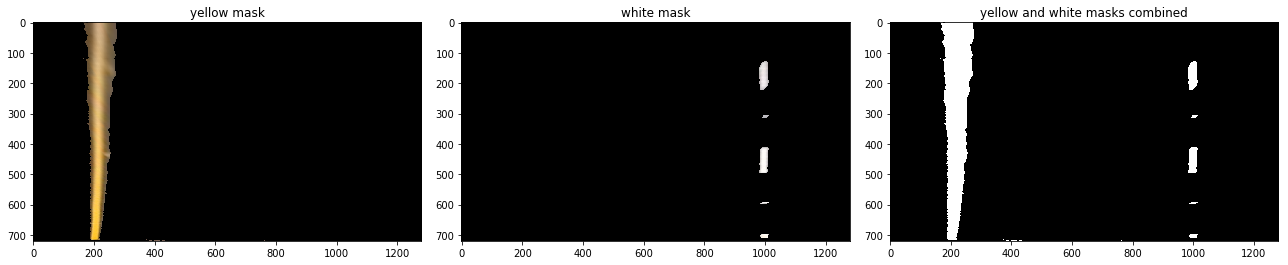

In [11]:
yellow_lines_binary, yellow_mask = yellow_lines(unwarp)
white_lines_binary, white_mask = white_lines(unwarp)
lane_mask = cv2.bitwise_or(yellow_mask, white_mask)

# plot and save image
images_to_plot = [yellow_lines_binary, white_lines_binary, lane_mask]
titles_to_plot = ['yellow mask', 'white mask', 'yellow and white masks combined']
out_file = "yellow_white_mask.png"
plot_images(rows=1, cols=3, images_to_plot=images_to_plot, titles_to_plot=titles_to_plot, out_file=out_file, cmap=[None,None,'gray'])

## 5. Gradient Thresholding

### 5.1 SobelX and SobelY

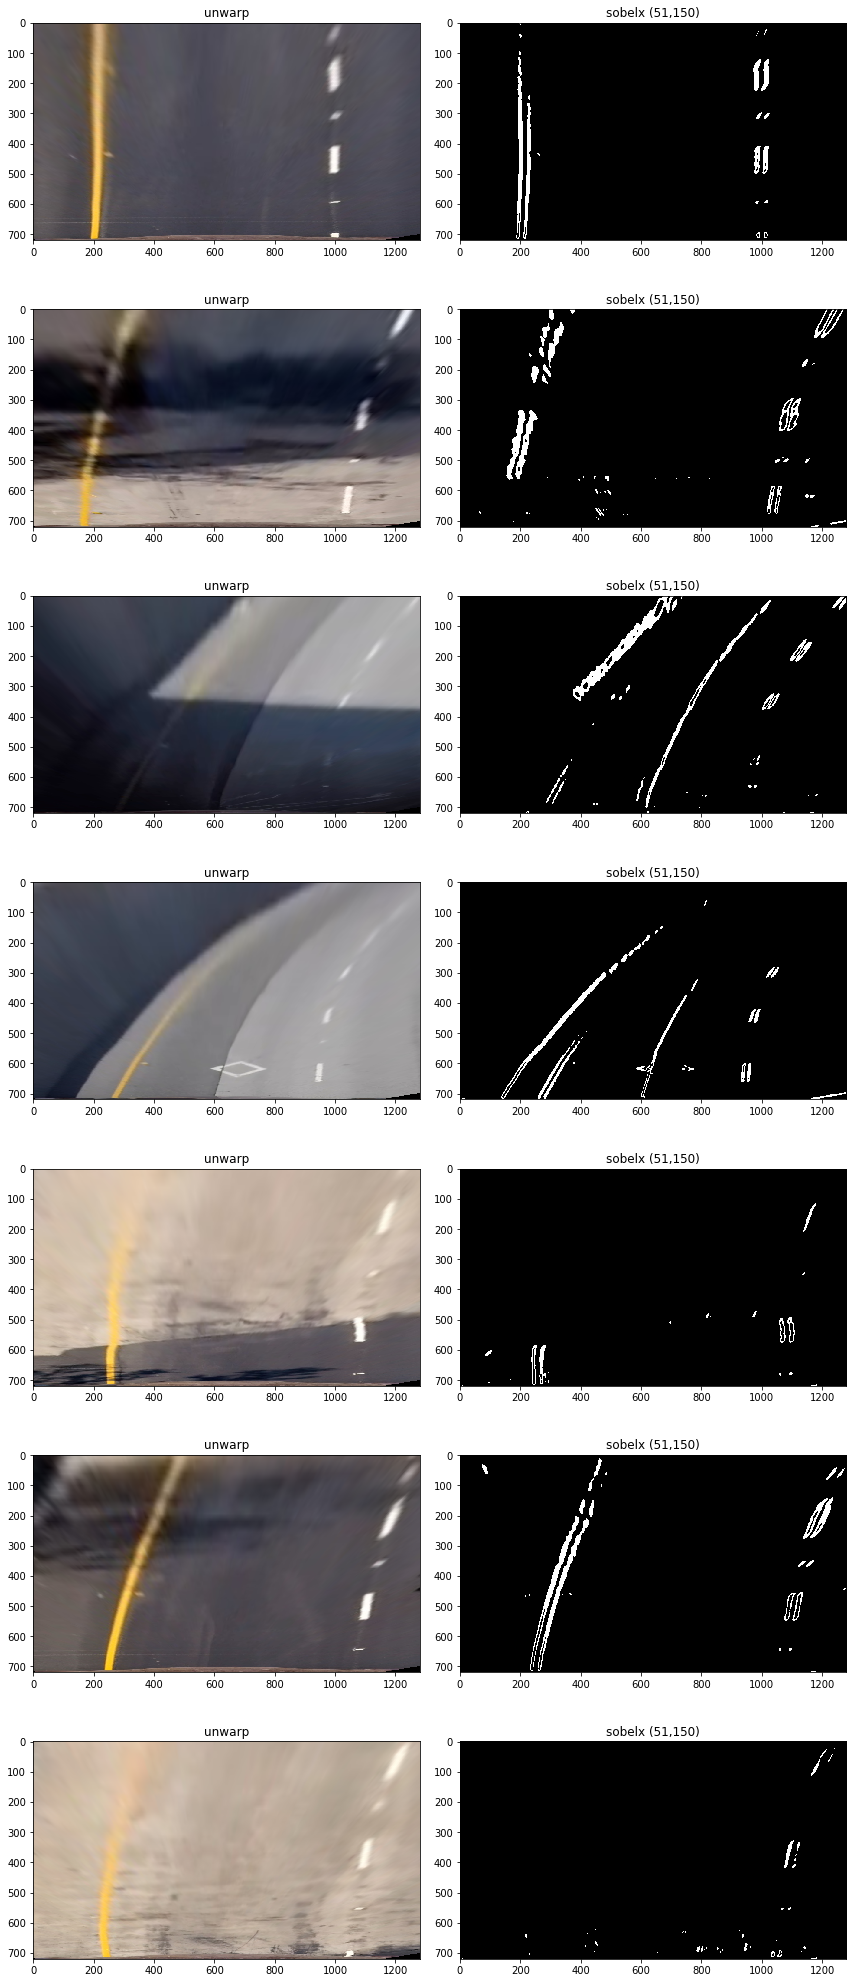

In [12]:
def updateSobel(orient, kernel, thresh_min, thresh_max):
    images_to_plot = []
    titles_to_plot = []
    cmaps_to_plot = []
    for idx in range(len(samples_unwarp)):
        sample_unwarp = samples_unwarp[idx]
        sample_gray_filtered = apply_filter(sample_unwarp)
        sample_gray_filtered_sobelx = abs_sobel_thresh(sample_gray_filtered, orient=orient, sobel_kernel=kernel, thresh=(thresh_min, thresh_max))
        images_to_plot.append(sample_unwarp)
        images_to_plot.append(sample_gray_filtered_sobelx)
        titles_to_plot.append('unwarp')
        titles_to_plot.append('sobel{} ({},{})'.format(orient, thresh_min, thresh_max))
        cmaps_to_plot.append(None)
        cmaps_to_plot.append('gray')
        
    # plot and save image
    out_file = "gradient_sobel{}.png".format(orient)
    plot_images(rows=len(sample_filename_list), cols=2, images_to_plot=images_to_plot, titles_to_plot=titles_to_plot, out_file=out_file, cmap=cmaps_to_plot)

interact(updateSobel,
         orient=['x', 'y'],
         kernel=(1,31,2),
         thresh_min=(0,255),
         thresh_max=(0,255))

### 5.3 SobelMag Thresholding

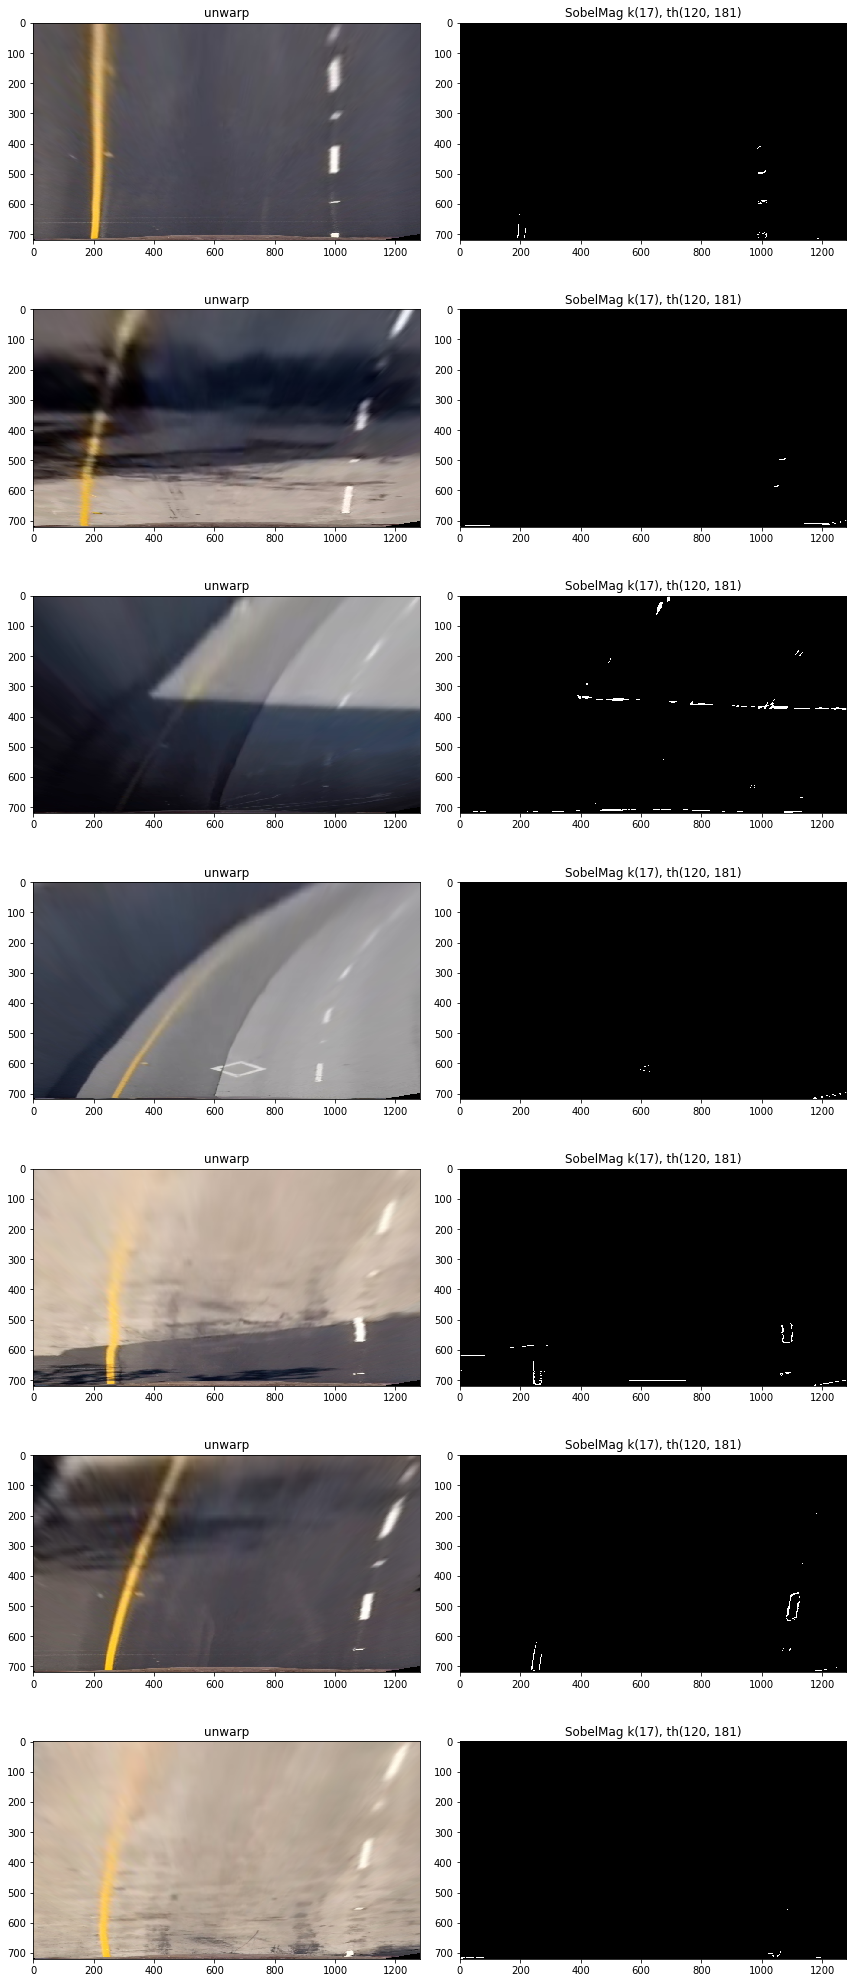

In [13]:
def updateSobelMag(ksize, thresh_min, thresh_max):
    
    images_to_plot = []
    titles_to_plot = []
    cmaps_to_plot = []
    for idx in range(len(samples_unwarp)):
        sample_unwarp = samples_unwarp[idx]
        out = mag_thresh(sample_unwarp, sobel_kernel=ksize, mag_thresh=(thresh_min, thresh_max))
        images_to_plot.append(sample_unwarp)
        images_to_plot.append(out)
        titles_to_plot.append('unwarp')
        titles_to_plot.append('SobelMag k({}), th({}, {})'.format(ksize, thresh_min, thresh_max))
        cmaps_to_plot.append(None)
        cmaps_to_plot.append('gray')
    out_file = "gradient_sobelMag.png"
    plot_images(rows=len(sample_filename_list), cols=2, images_to_plot=images_to_plot, titles_to_plot=titles_to_plot, out_file=out_file, cmap=cmaps_to_plot)

interact(updateSobelMag, 
         ksize=(3,31,2),
         thresh_min=(0,255),
         thresh_max=(0,255))

### 5.4 Sobel Direction Thresholding

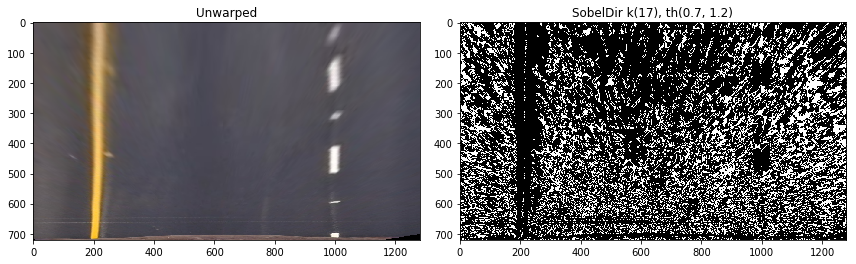

In [14]:
def updateSobelDir(ksize, thresh_min, thresh_max):
    out = dir_threshold(unwarp, sobel_kernel=ksize, thresh=(thresh_min, thresh_max))
    images_to_plot = [unwarp, out]
    titles_to_plot = ['Unwarped', 'SobelDir k({}), th({}, {})'.format(ksize, thresh_min, thresh_max)]
    out_file = "gradient_sobelDir.png"
    plot_images(rows=1, cols=2, images_to_plot=images_to_plot, titles_to_plot=titles_to_plot, out_file=out_file, cmap=[None,'gray'])

interact(updateSobelDir,
         ksize=(3,31,2),
         thresh_min=(0.0,3.0),
         thresh_max=(0.0,3.0))

## 6. Pipeline

In [15]:
def pipeline(image):
    # chosen kernel size
    ksize = 31 # Choose a larger odd number to smooth gradient measurements

    # selected Gradient threshold
    gradx = abs_sobel_thresh(apply_filter(image), orient='x', sobel_kernel=ksize, thresh=(50, 150))

    # yellow and white lanes mask
    yellow_lines_binary, yellow_mask = yellow_lines(image)
    white_lines_binary, white_mask = white_lines(image)
    lane_mask = cv2.bitwise_or(yellow_mask, white_mask)
    lane_mask = lane_mask/255.0
    
    combined = np.zeros_like(gradx)
    combined[((gradx == 1) | (lane_mask == 1))] = 1
    
    return combined

## 7. Test Images

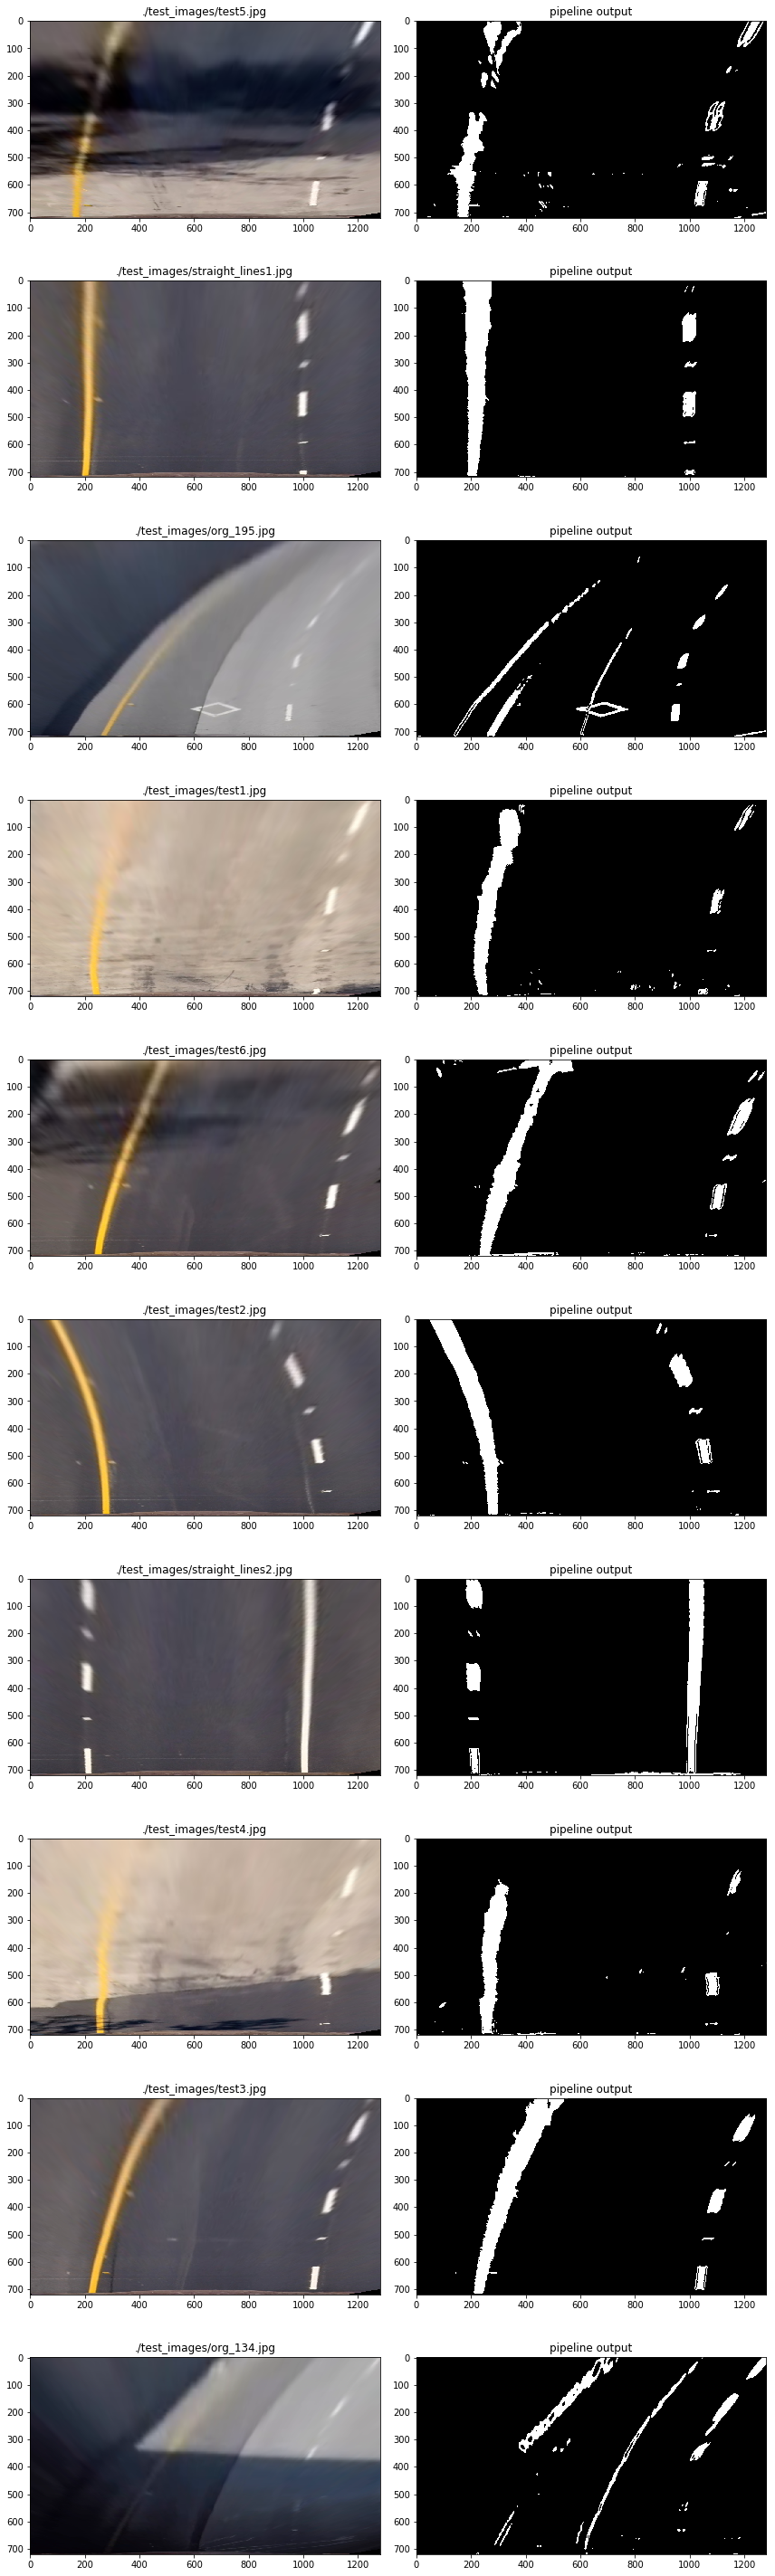

In [16]:
# try against all test images
images = glob.glob('./test_images/*.jpg')

# process and plot pipeline output for test images
images_to_plot = []
titles_to_plot = []
cmaps_to_plot = []
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undist = undistort_image(img, mtx, dist)
    unwarp_test,M_test,Minv_test = unwarp_image(undist, src, dst)
    
    # process through pipeline
    img_out = pipeline(unwarp_test)

    images_to_plot.append(unwarp_test)
    titles_to_plot.append(fname)
    cmaps_to_plot.append(None)
    images_to_plot.append(img_out)
    titles_to_plot.append('pipeline output')
    cmaps_to_plot.append('gray')
out_file = "test_pipeline.png"
plot_images(rows=len(images), cols=2, images_to_plot=images_to_plot, titles_to_plot=titles_to_plot, out_file=out_file, cmap=cmaps_to_plot)

## 8. Locate the Lane Lines and Fit a Polynomial

### 8.1 Histogram

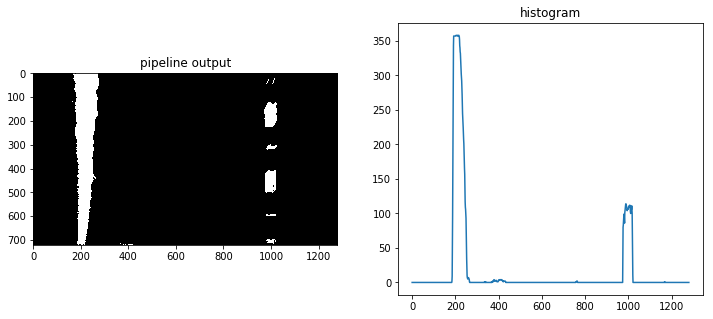

In [17]:
# ger outimage from pipeline
img_out = pipeline(unwarp)

# Assuming you have created a warped binary image called "binary_warped"
binary_warped = img_out

# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

fig = plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(img_out, cmap='gray')
plt.title('pipeline output')
plt.subplot(122)
plt.plot(histogram)
plt.title('histogram')
fig.savefig('./output/pipeline_histogram.png')
plt.show()

In [18]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

print("Left base: {} Right base: {} Diff : {}".format(leftx_base, rightx_base, (rightx_base - leftx_base)))

Left base: 203 Right base: 988 Diff : 785


### 8.2 Sliding Window approach

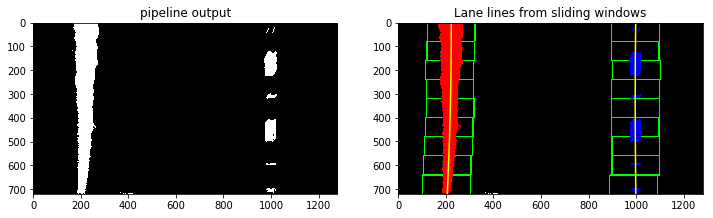

In [19]:
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Set the width of the windows +/- margin
margin = 100

# Set minimum number of pixels found to recenter window
minpix = 50

# windows
nwindows = 9

# Create empty lists to receive left and right lane pixel indices
left_lane_inds, right_lane_inds, leftx_current, rightx_current = sliding_windows(
    binary_warped, out_img, nonzerox, nonzeroy, leftx_current, rightx_current, margin, minpix, nwindows)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# update out image
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

#plot
fig = plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(img_out, cmap="gray")
plt.title("pipeline output")
plt.subplot(122)
plt.imshow(out_img)
plt.title("Lane lines from sliding windows")
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
fig.savefig('./output/sliding_window.png')
plt.show()

### 8.3 Left and Right Curvature (in pixels)¶

In [20]:
y_eval = np.max(lefty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print("Left curvature : {:.2f} px  Right curvature : {:.2f} px".format(left_curverad, right_curverad))
# Example values: 1926.74 1908.48

Left curvature : 14396.31 px  Right curvature : 29506.38 px


### 8.4 Left and Right Curvature (in meters)

In [21]:
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

# Now our radius of curvature is in meters
print("Left curvature : {:.2f} m  Right curvature : {:.2f} m".format(left_curverad, right_curverad))
# Example values: 632.1 m    626.2 m

Left curvature : 4712.17 m  Right curvature : 9689.02 m


### 8.5 Distance of the car from the center of the lane

In [22]:
img_center = binary_warped.shape[1] / 2
lane_center = (left_fit[-1] + right_fit[-1]) / 2
diff = lane_center - img_center
print("Distance from center : {:.2f} m".format(diff * xm_per_pix))

center_fit = (left_fit + right_fit) / 2
center_curverad = ((1 + (2 * center_fit[0] * y_eval * ym_per_pix + center_fit[1])**2)**1.5) / np.absolute(2 * center_fit[0])
print("Curvature : {:.2f} m ".format(center_curverad))

Distance from center : -0.16 m
Curvature : 55856.68 m 


### 8.6 Plot Selection Window

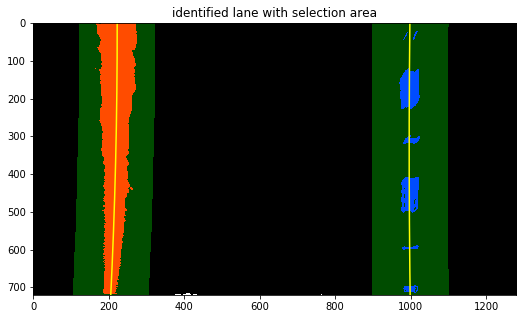

In [23]:
# get selection window/area
result = add_selection_window(binary_warped, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, left_fitx, right_fitx, ploty, margin)

# plot
fig = plt.figure(figsize=(12,5))
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.title('identified lane with selection area')
fig.savefig('./output/lane_selected_area.png')
plt.show()

### 8.7 Overlay

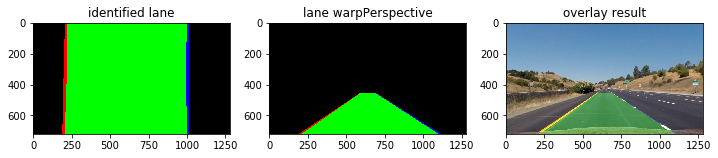

In [24]:
warped = img_out

# add overlay
result, color_warp, newwarp = add_overlay(warped, undist_img, Minv, left_fitx, right_fitx, ploty)

# plot
fig = plt.figure(figsize=(12,5))
plt.subplot(131)
plt.imshow(color_warp)
plt.title("identified lane")
plt.subplot(132)
plt.imshow(newwarp)
plt.title("lane warpPerspective")
plt.subplot(133)
plt.imshow(result)
plt.title("overlay result")
fig.savefig('./output/overlay.png')
plt.show()

## 9. Alternate approach to Sliding Window for finding lane lines

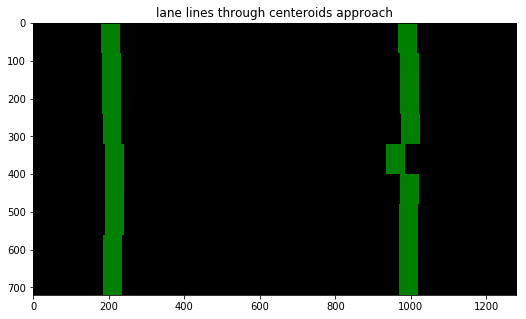

In [25]:
warped = img_out

# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results 

# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
fig = plt.figure(figsize=(12,5))
plt.imshow(output)
plt.title('lane lines through centeroids approach')
fig.savefig('./output/centeriod.png')
plt.show()